# NeRF Activation Sparsity
Run the `accelerating_nerfs/nerf_activation_sparsity.py` script to compute the sparsities. You need to use the NeRF environment for that.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from typing import Optional

# Custom code
from analysis import load_nerf_sparsities
from notebook_utils import load_mpl_style

load_mpl_style()
fig_dir = "figures/activation"
os.makedirs(fig_dir, exist_ok=True)

In [2]:
!ls ../accelerating_nerfs/sparsity

chair_sparsity.json  hotdog_sparsity.json     mic_sparsity.json
drums_sparsity.json  lego_sparsity.json       ship_sparsity.json
ficus_sparsity.json  materials_sparsity.json


In [3]:
# Load and process scene sparsity results
sparsity_results = load_nerf_sparsities("../accelerating_nerfs/sparsity")
scene_to_sparsity = defaultdict(dict)

for scene, results in sparsity_results.items():
    for layer, fc_label in zip(results["layers"], results["fc_labels"]):
        layer_id = int(fc_label.split('_')[1])
        # Calculate mean and std of input and output sparsities
        input_sparsities = np.array(results["input"]["sparsities"][layer])
        output_sparsities = np.array(results["output"]["sparsities"][layer])
        assert len(input_sparsities) == len(output_sparsities)
        scene_to_sparsity[scene][layer_id] = {
            "input_sparsity": np.mean(input_sparsities),
            "input_sparsity_std": np.std(input_sparsities),
            "input_sparsities": input_sparsities,
            "output_sparsity": np.mean(output_sparsities),
            "output_sparsity_std": np.std(output_sparsities),
            "output_sparsities": output_sparsities,
            "num": len(input_sparsities),
            "layer": layer,
        }
        
# Convert into dataframes
dfs = [pd.DataFrame.from_dict(results, orient="index") for results in scene_to_sparsity.values()]

Loaded sparsity results for dict_keys(['chair', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic', 'ship'])


## Plot input activation sparsity for each FC layer
Notes:

- `fc_1` is the layer that gets the position encoded ray samples
- `fc_11` is the first hidden layer of the RGB MLP, that gets input from the bottleneck layer which doesn't have an activation function.

===== chair =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6415253583261931
===== drums =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6547293642000122
===== ficus =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6599154698974414
===== hotdog =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6512334966586046
===== lego =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6408965191841306
===== materials =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6642717437667441
===== mic =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6644339064907115
===== ship =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mea

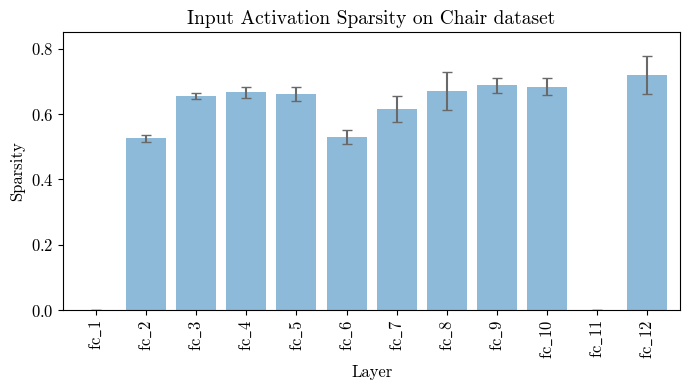

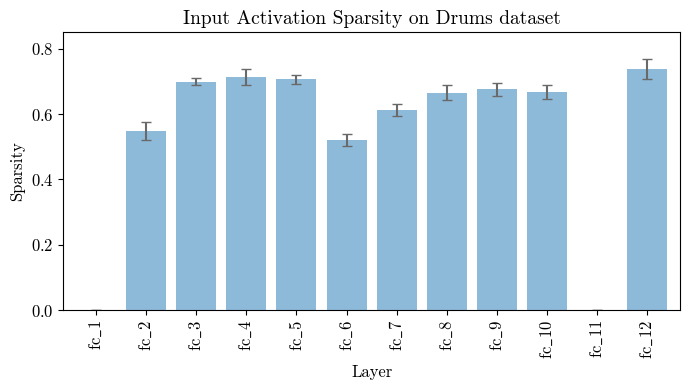

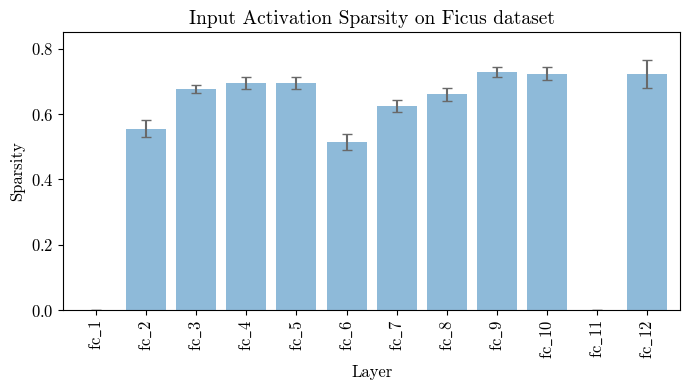

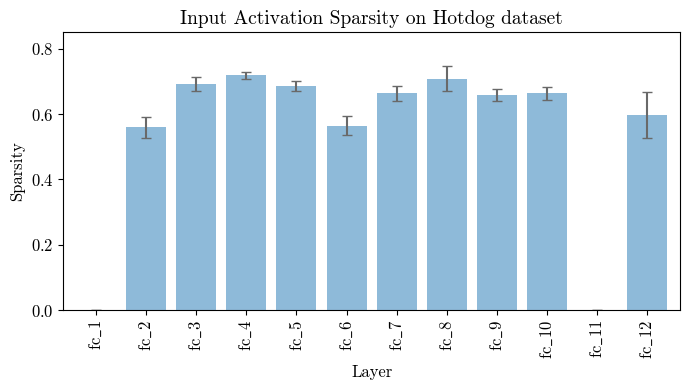

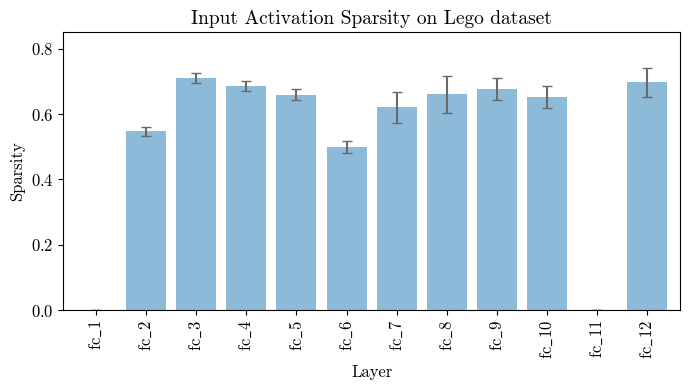

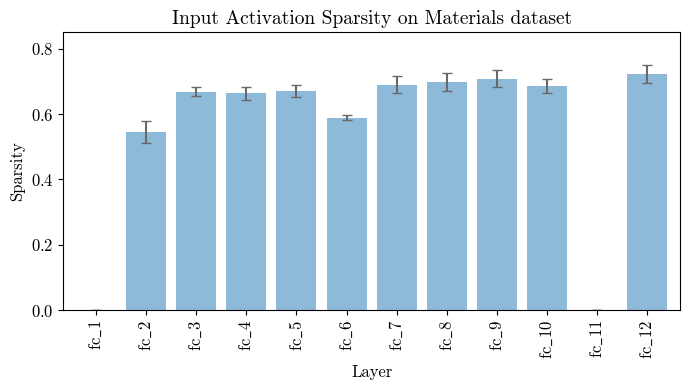

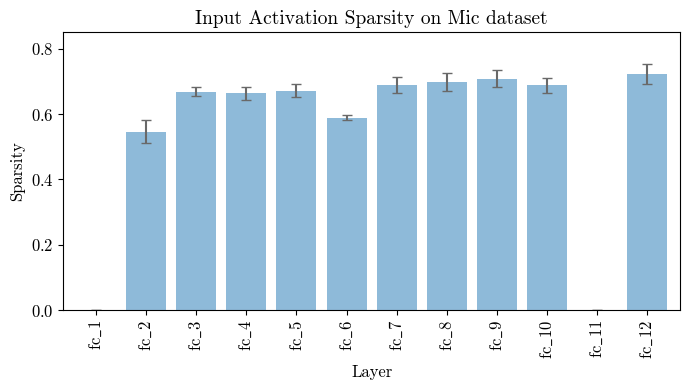

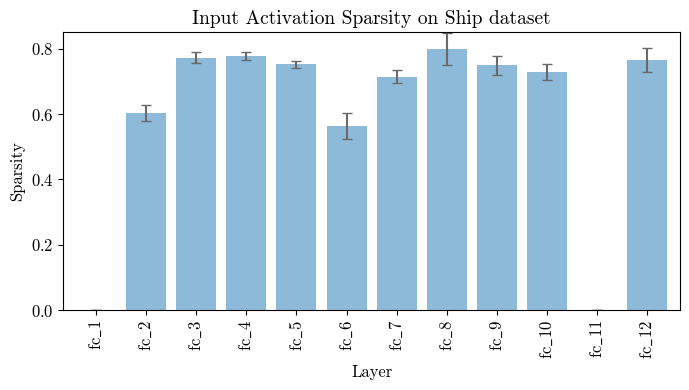

In [4]:
def plot(sparsity_type: str, y_lim: Optional[float] = None):
    assert sparsity_type in {"input", "output"}
    
    mean_sparsities = []
    sparsity_key = f"{sparsity_type}_sparsity"
    sparsity_std_key = f"{sparsity_type}_sparsity_std"
    
    for label, df in zip(scene_to_sparsity.keys(), dfs):
        # err = 1.96 * df[sparsity_std_key] / np.sqrt(df['num'])
        err = df[sparsity_std_key]
        ax = df.plot.bar(
            y=sparsity_key, yerr=err, width=0.8, figsize=(7, 4), 
            align='center', alpha=0.5, ecolor='dimgray', capsize=3.5
        )
        ax.set_xticklabels(["$\mathrm{fc}\_" + str(v.item()) + "$" for v in df.index.values])
        ax.get_legend().remove()
        ax.set_title(f"{sparsity_type.capitalize()} Activation Sparsity on {label.capitalize()} dataset")
        ax.set_xlabel("Layer")
        ax.set_ylabel("Sparsity")
        if y_lim is not None:
            ax.set_ylim(0.0, y_lim)
        ax.figure.tight_layout()
        ax.figure.savefig(f"{fig_dir}/{label}_{sparsity_type}_sparsity.pdf")

        df_has_sparsity = df[df[sparsity_key] > 0.01]
    
        print(f"===== {label} =====")
        print(f"Layers with sparsity: {df_has_sparsity.index.values}")
        mean_sparsity = df_has_sparsity[sparsity_key].mean()
        print(f"mean sparsity over layers with sparsity: {mean_sparsity}")
        mean_sparsities.append(mean_sparsity)
    
    print('==========')
    print(f"Overall {sparsity_type} activation mean sparsity: {np.mean(mean_sparsities)}")


plot("input", y_lim=0.85)

## Plot output activation sparsity for each FC layer

===== chair =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6529815066981803
===== drums =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6708778100344661
===== ficus =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6750487494957764
===== hotdog =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6624024415305413
===== lego =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6543895694135887
===== materials =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6705915114853352
===== mic =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6708293120058345
===== ship =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mea

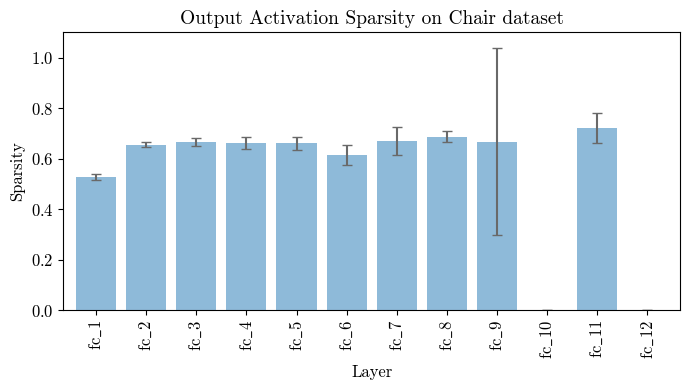

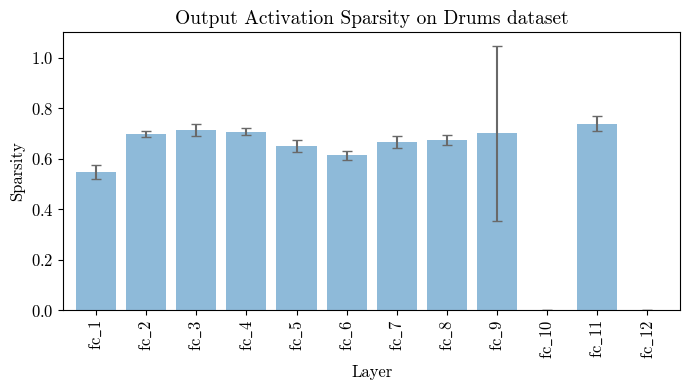

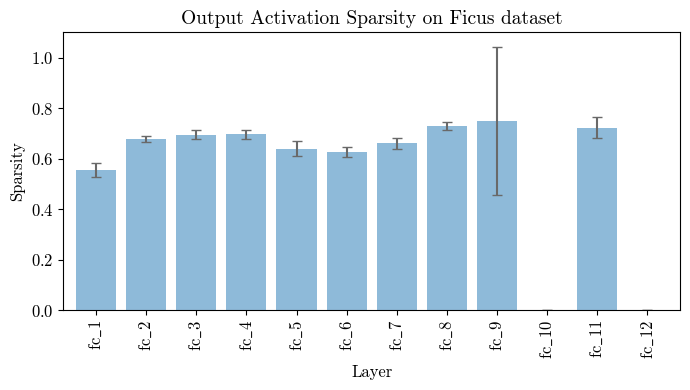

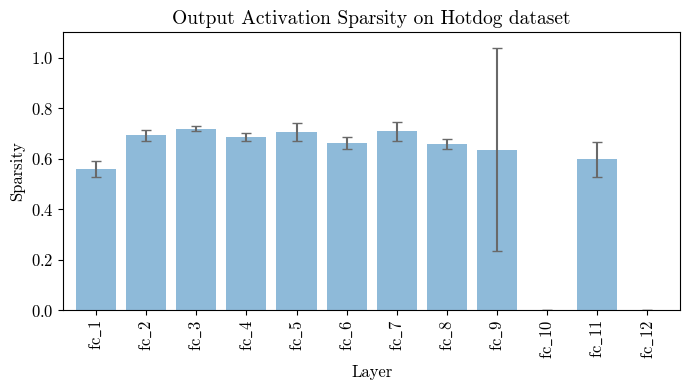

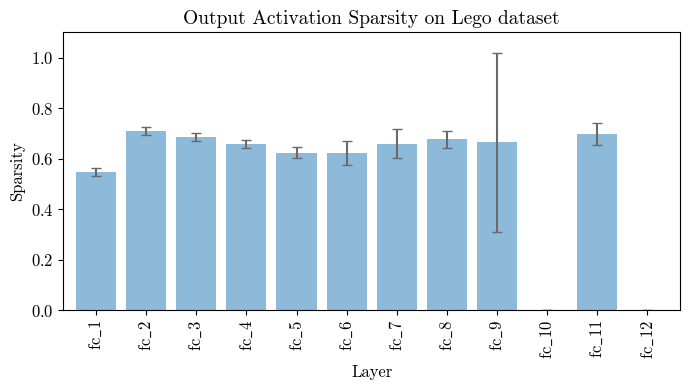

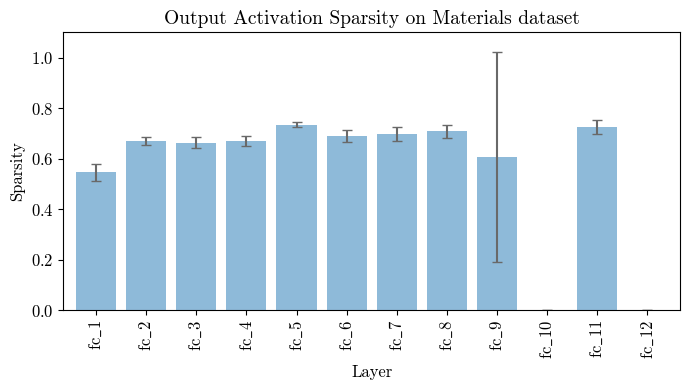

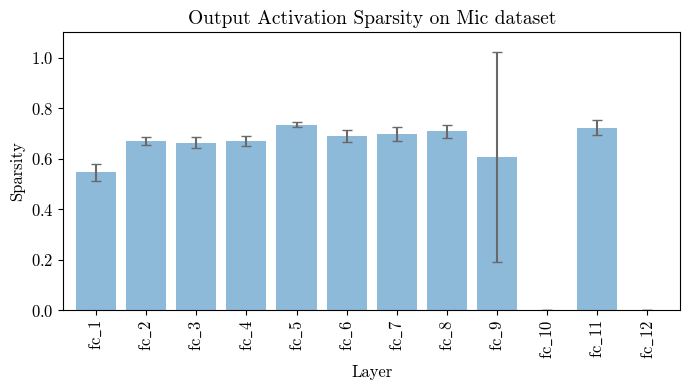

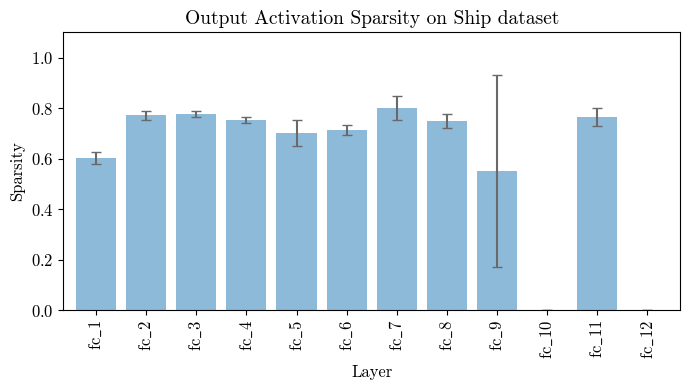

In [5]:
plot("output", y_lim=1.1)

## View NeRF architecture

In [6]:
from IPython.display import IFrame
IFrame("./figures/netdiag-modified.pdf", width=600, height=325)